<a href="https://colab.research.google.com/github/project-ida/two-state-quantum-systems/blob/master/05-many-two-state-systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <a href="https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/05-many-two-state-systems.ipynb" target="_parent"><img src="https://nbviewer.jupyter.org/static/img/nav_logo.svg" alt="Open In nbviewer" width="100"/></a>

# 5 - Many two state systems

> TODO: Intro

In [458]:
# Libraries
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from IPython.display import Image
import gif
import numpy as np
import pandas as pd
from qutip import *
from qutip.piqs import *
import warnings
warnings.filterwarnings('ignore')
from itertools import product
import os

In [185]:
spins = spin_algebra(2)

In [186]:
spins[2]

[Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
 Qobj data =
 [[ 0.5  0.   0.   0. ]
  [ 0.   0.5  0.   0. ]
  [ 0.   0.  -0.5  0. ]
  [ 0.   0.   0.  -0.5]],
 Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
 Qobj data =
 [[ 0.5  0.   0.   0. ]
  [ 0.  -0.5  0.   0. ]
  [ 0.   0.   0.5  0. ]
  [ 0.   0.   0.  -0.5]]]

In [196]:
H = spins[2][0] + spins[2][1] + A*spins[0][0] + A*spins[0][1]

In [277]:
H

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  -0.1]
 [-0.1 -1. ]]

In [415]:
def make_df_for_energy_scan(label_param, min_param, max_param, num_param, num_levels):
    
    # creates an empty dictionary to store the row/column information
    d = {}
    
    # creates array of parameter values that we want to scan through
    param_values = np.linspace(min_param, max_param, num_param)
    
    # stores the parameter scan label and values (this will soon become the first column in the dataframe)
    d[label_param] = param_values
    
    # creates empty columns to store the eigenvalues for the different levels later on
    # num_levels will be the number of rows of H (or any of the operators that make up H)
    for i in range(num_levels):
        d[f"level_{i}"] = np.zeros(num_param)
     
    # creates the dataframe
    df = pd.DataFrame(data=d)
    
    return df

In [417]:
df = make_df_for_energy_scan("$\delta$/A", -40,40, 100, spins[2][0].shape[0])

In [418]:
spins[2][1]+spins[2][0]


Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0. -1.]]

In [419]:
A=0.1
for i, row in df.iterrows():
    H =  row[ "$\delta$/A"]*A*spins[2][0] + row[ "$\delta$/A"]*A*spins[2][1] + A*spins[0][0] + A*spins[0][1]
    evals, ekets = H.eigenstates()
    df.iloc[i,1:] = evals

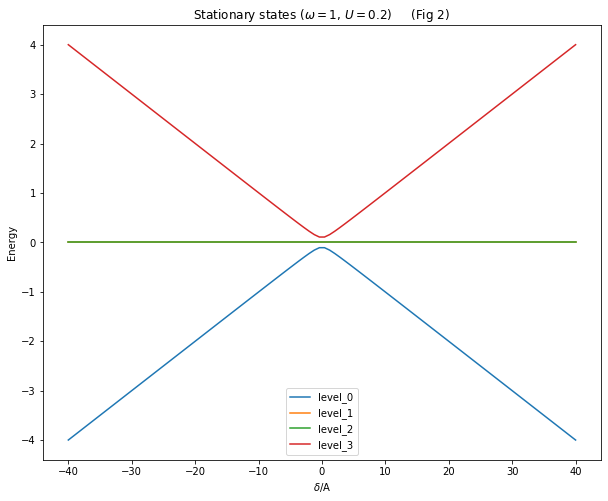

In [420]:
df.plot(x="$\delta$/A",figsize=(10,8),legend=True, 
        title="Stationary states ($\omega=1$, $U=0.2$)     (Fig 2)");
plt.ylabel("Energy");

In [803]:
delE = 1

In [804]:
A = 0.01

In [805]:
H = delE*spins[2][0] + delE*spins[2][1] + A*spins[0][0] + A*spins[0][1]

In [806]:
H

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 1.     0.005  0.005  0.   ]
 [ 0.005  0.     0.     0.005]
 [ 0.005  0.     0.     0.005]
 [ 0.     0.005  0.005 -1.   ]]

In [807]:
evals, ekets = H.eigenstates()

In [808]:
evals

array([-1.0000500e+00, -8.8817842e-16,  0.0000000e+00,  1.0000500e+00])

In [809]:
ekets

array([Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 2.49981252e-05]
 [-4.99975002e-03]
 [-4.99975002e-03]
 [ 9.99975002e-01]],
       Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 0.00707071]
 [-0.70707143]
 [-0.70707143]
 [-0.00707071]],
       Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 0.        ]
 [-0.70710678]
 [ 0.70710678]
 [ 0.        ]],
       Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[9.99975002e-01]
 [4.99975002e-03]
 [4.99975002e-03]
 [2.49981252e-05]]], dtype=object)

In [810]:
J = jspin(2, basis="uncoupled")

In [811]:
Jx = J[0]
Jy = J[1]
Jz = J[2]

In [812]:
H = delE*Jz + A*Jx

In [813]:
H

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 1.     0.005  0.005  0.   ]
 [ 0.005  0.     0.     0.005]
 [ 0.005  0.     0.     0.005]
 [ 0.     0.005  0.005 -1.   ]]

In [814]:
J2 = Jx**2 + Jy**2 + Jz**2

In [815]:
J2

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[2. 0. 0. 0.]
 [0. 1. 1. 0.]
 [0. 1. 1. 0.]
 [0. 0. 0. 2.]]

In [816]:
commutator(H,J2)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

In [817]:
J2.transform(ekets)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[2. 0. 0. 0.]
 [0. 2. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 2.]]

In [818]:
J = jspin(2)

In [819]:
Jx = J[0]
Jy = J[1]
Jz = J[2]

In [820]:
A = 0.01

In [821]:
H = delE*Jz + A*Jx

In [822]:
H

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 1.          0.00707107  0.          0.        ]
 [ 0.00707107  0.          0.00707107  0.        ]
 [ 0.          0.00707107 -1.          0.        ]
 [ 0.          0.          0.          0.        ]]

In [823]:
J2 = Jx**2 + Jy**2 + Jz**2

In [788]:
J2

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[2. 0. 0. 0.]
 [0. 2. 0. 0.]
 [0. 0. 2. 0.]
 [0. 0. 0. 0.]]

In [774]:
from qutip.cy.piqs import j_min, j_vals, m_vals

In [830]:
N = 2
i=0

nm_list = []
j_index = {}

js = j_vals(N)[::-1]
for j in js:
    j_index[j] = []
    ms = m_vals(j)[::-1]
    for m in ms:
        j_index[j].append(i)
        nm_list.append((j,m))
        i+=1

In [831]:
nm_list

[(1.0, 1.0), (1.0, 0.0), (1.0, -1.0), (0.0, -0.0)]

In [837]:
def make_braket_labels(nm_list):
    bra_labels = ["$\langle$"+str(n)+", "+str(m)+" |" for (n,m) in nm_list]
    ket_labels = ["| "+str(n)+", "+str(m)+"$\\rangle$" for (n,m) in nm_list]
    return bra_labels, ket_labels

In [840]:
bra_labels, ket_labels = make_braket_labels(nm_list)

In [851]:
Jz1 = Jz.extract_states(j_index[1])
Jx1 = Jx.extract_states(j_index[1])

In [852]:
df = make_df_for_energy_scan("$\delta$/A", -4,4, 100, Jz1.shape[0])

In [853]:
A=0.1
for i, row in df.iterrows():
    H =  row[ "$\delta$/A"]*A*Jz1 + A*Jx1
    evals, ekets = H.eigenstates()
    df.iloc[i,1:] = evals

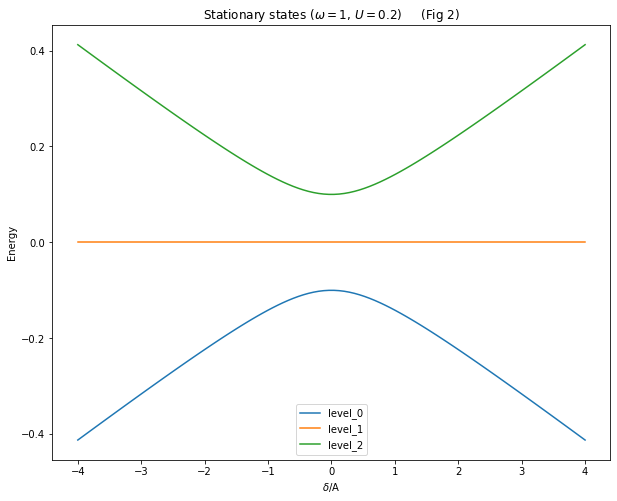

In [854]:
df.plot(x="$\delta$/A",figsize=(10,8),legend=True, 
        title="Stationary states ($\omega=1$, $U=0.2$)     (Fig 2)");
plt.ylabel("Energy");

[Wolfram alpha eigenvalues](https://www.wolframalpha.com/input/?i=%7B%7B1%2Ca%2C0%7D%2C%7Ba%2C0%2Ca%7D%2C%7B0%2Ca%2C-1%7D%7D+eigenvalues)